In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime

import sys
sys.path.append('src')

In [3]:
from gecko.data import JPEGDataLoader

In [97]:
loader = JPEGDataLoader(camera='c3')

In [98]:
loader.base_url

'https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/<<<YEAR>>>/c3/'

In [99]:
from functools import reduce
from PIL import Image

In [107]:
start_datetime = datetime.datetime(2008, 7, 8, 7, 41, 0)
end_datetime = datetime.datetime(2008, 7, 8, 15, 45, 0)

images_paths = loader.ls_images(start_datetime, end_datetime)
images = [loader.get_image(x) for x in images_paths]

In [108]:
images_paths

['20080708_0742_c3_1024.jpg',
 '20080708_0818_c3_1024.jpg',
 '20080708_0842_c3_1024.jpg',
 '20080708_0918_c3_1024.jpg',
 '20080708_0942_c3_1024.jpg',
 '20080708_1019_c3_1024.jpg',
 '20080708_1042_c3_1024.jpg',
 '20080708_1118_c3_1024.jpg',
 '20080708_1142_c3_1024.jpg',
 '20080708_1218_c3_1024.jpg',
 '20080708_1242_c3_1024.jpg',
 '20080708_1318_c3_1024.jpg',
 '20080708_1342_c3_1024.jpg',
 '20080708_1418_c3_1024.jpg',
 '20080708_1442_c3_1024.jpg',
 '20080708_1542_c3_1024.jpg']

In [109]:
from gecko.transform import Blender

In [110]:
blender = Blender(alpha=30)

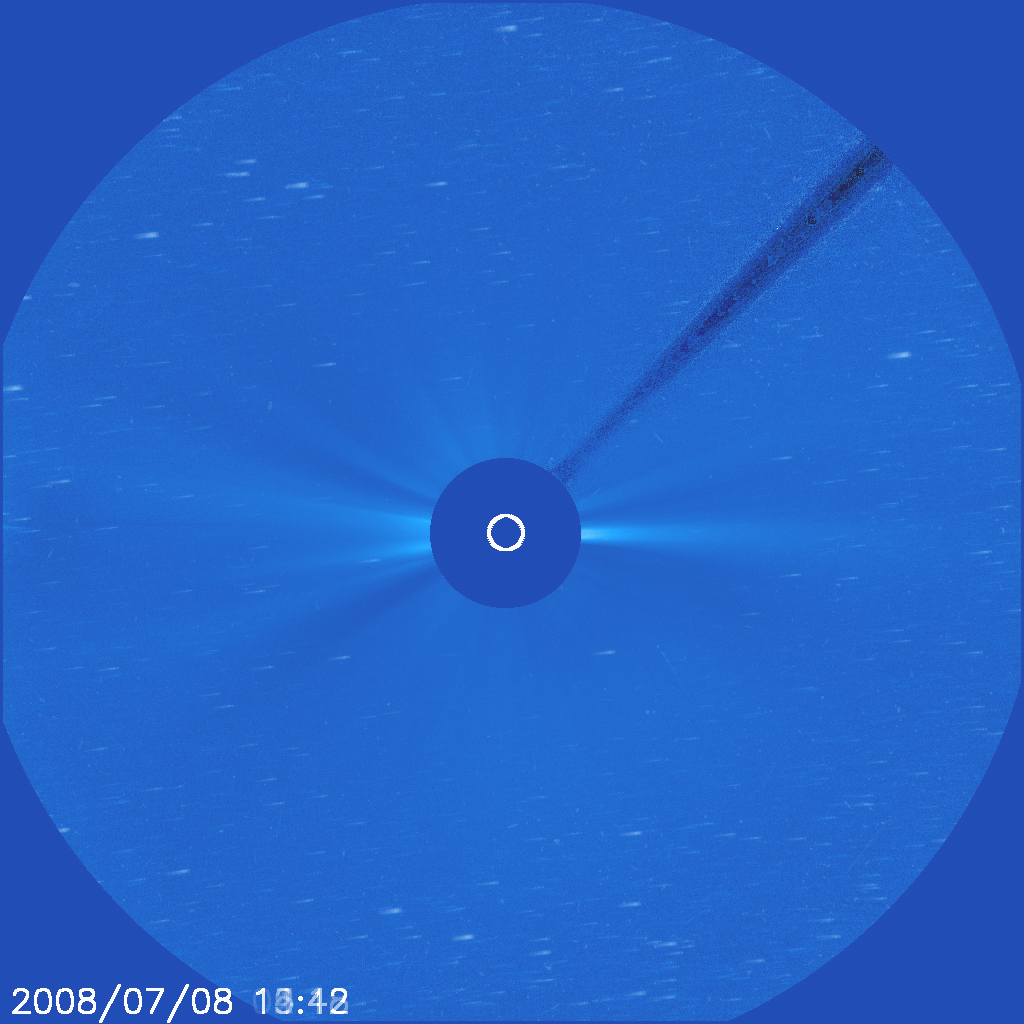

In [111]:
blender.blend(images)

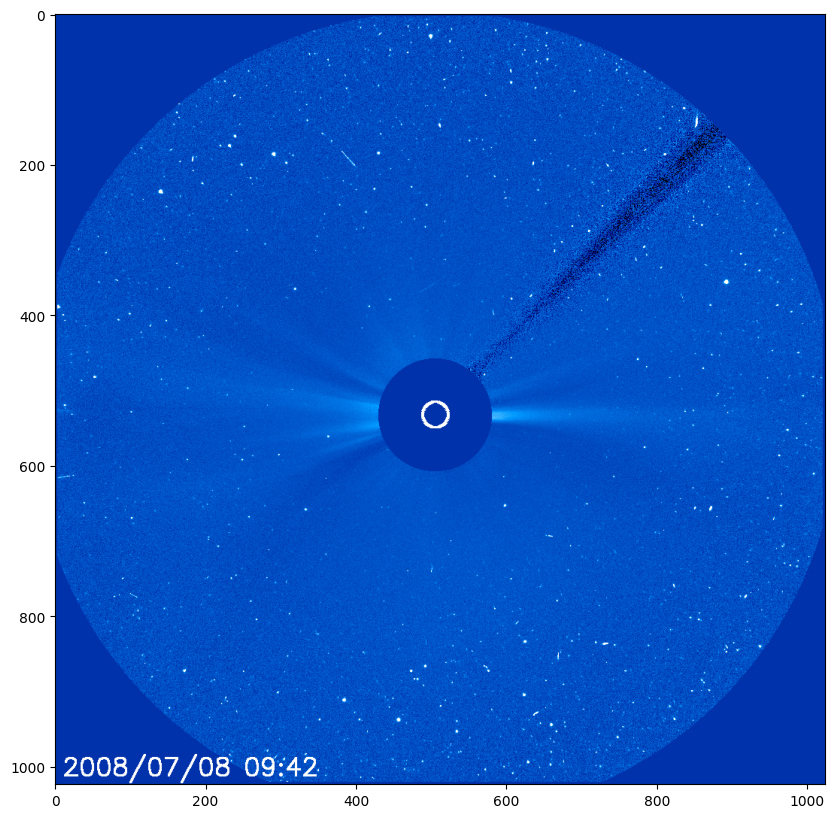

In [118]:
import matplotlib.pyplot as plt
import numpy as np

image = images[4]

img_pil = image.convert('RGBA') 
img = np.asarray(img_pil)


fig, ax = plt.subplots(figsize=(10, 10), sharex=True, sharey=True)
# ax.axhline(440, color='blue')
# ax.axvline(990, color='blue')

imgplot = plt.imshow(img, cmap='gray')

In [131]:
img_copy = img.copy()
img_copy.setflags(write=1)
for i in range(img_copy.shape[0]):
    for j in range(img_copy.shape[1]):
        if all([img_copy[i][j][0] > 120, img[i][j][1] > 120, img[i][j][2] > 120]):
            img_copy[i][j] = [0, 0, 0, 255]
            for i_delta in range(-1, 1):
                for j_delta in range(-1, 1):
                    try:
                        img_copy[i+i_delta][j+j_delta] = [0, 0, 0, 255]
                    except:
                        pass
        else:
            img_copy[i][j] = [255, 255, 255, 255]

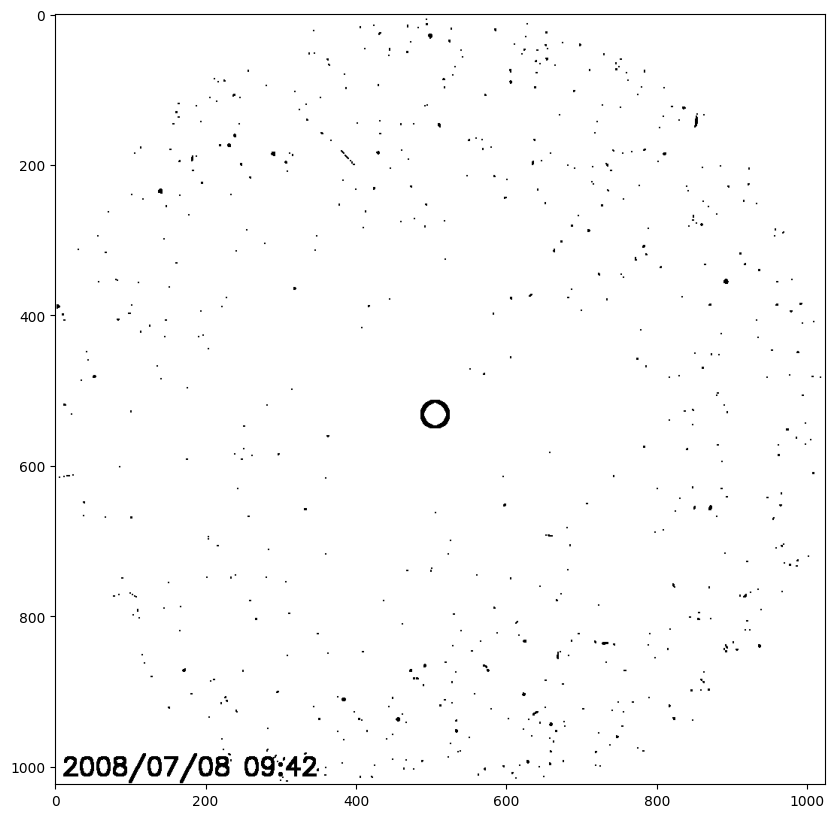

In [132]:
fig, ax = plt.subplots(figsize=(10, 10), sharex=True, sharey=True)
# ax.axhline(440, color='blue')
# ax.axvline(990, color='blue')

imgplot = plt.imshow(img_copy, cmap='gray')

In [151]:
from gecko.transform import Simplifier

In [163]:
simplifier = Simplifier(level=100, add_pixels=2)

In [169]:
blender = Blender(alpha=70)

In [172]:
blended_img = blender.blend([simplifier.transform(x) for x in images[:5]])

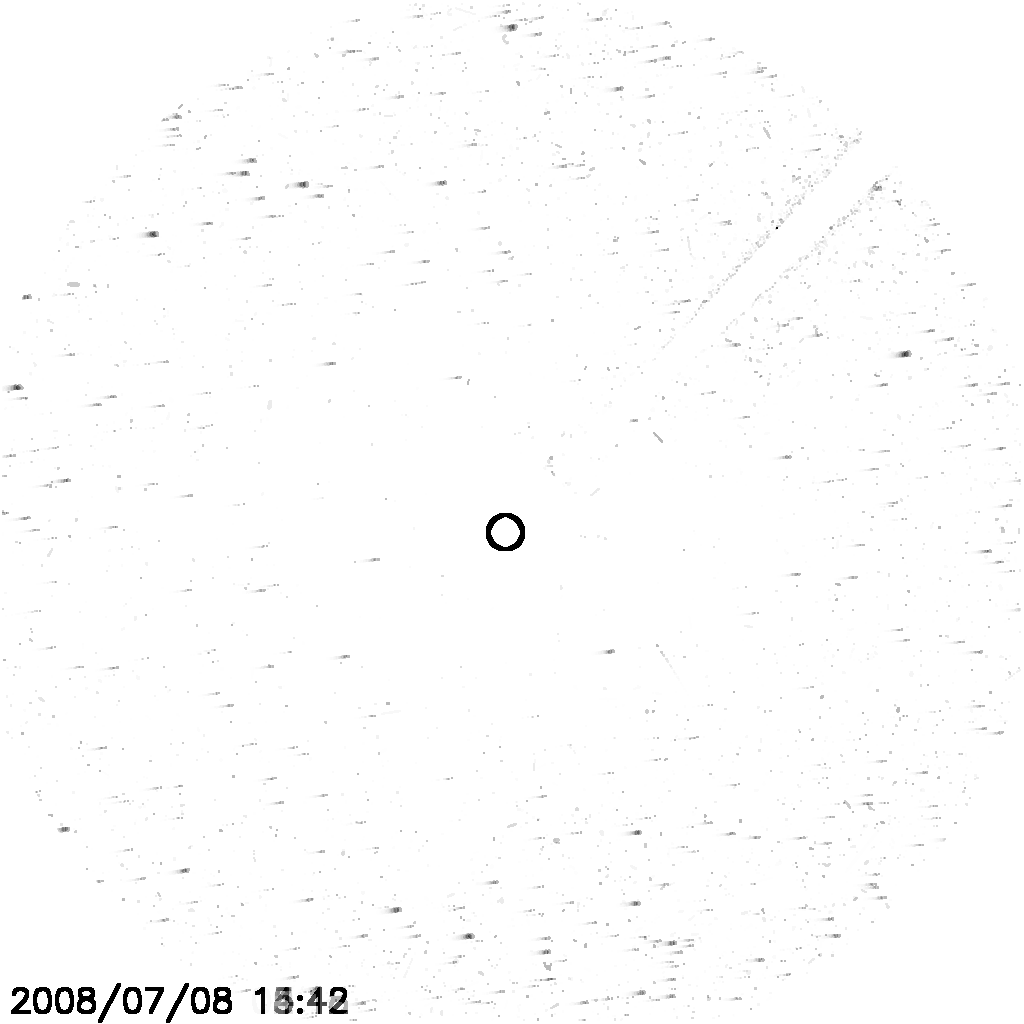

In [ ]:
blended_img